## Caltech Bird Image Dataset fastai solution (with limited birds)


Most of this notebook follows the outline provided in the fastai course. 
If you want to see the complete notebook, and run it against the full Caltech-UCSD data set
look at my Kaggle notebook (https://www.kaggle.com/mesadowski/caltech-ucsd-bird-image-dataset-fastai).  This notebook has been altered slighly to just run against the 
I specific dataset I've created, which is a combination of birds native to the Northeast US, spiked
with some extra pictures that I've provided to ensure that my algorithm can identify squirrels and 
a couple of extra birds (e.g., Carolina Chickadees) which for some reason are not in Caltech-UCSD and which are common in my area.

If you want to try this, I suggest running it in Google Colab. You get some free GPU hours, and you don't need to pay to fire up your own server. To run this (using Google Colab) you need to put folders with the appropriate bird photos in your Google Drive (in a folder called /content/drive/MyDrive/Bird_Images), and connect it to Colab. I just draggred the relevant folders from the Caltech-UCSD data set into Google Drive, and then added my own folders for birds (and squirrels) that are not in the data set, but which I see in my backyard. The first cell of the notebook will ask you to link your Google Drive with Colab and enter an authorization code, so do that. 

Turn on the GPU before running this. This is going to be way too slow if you try to run it on a CPU.  

In [1]:
# install the fastai libraries and import them.  At this point Google Colab will ask you to 
# enter an authorization code to connect to your Google Drive
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 23.4MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 1.1MB 52.9MB/s 
     |████████████████████████████████| 194kB 55.4MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.all import *
from fastai.callback.fp16 import *

In [ ]:
mount google drive to store the notebook, output, etc.
from google.colab import drive
drive.mount('/content/drive')

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#Conveniently, fastai knows about the data set already
#URLs.CUB_200_2011

In [10]:
# get the image dataset and unzip it
path = Path('/content/drive/MyDrive/Bird_Images')
path

Path('/content/drive/MyDrive/Bird_Images')

In [11]:
# Set the bast path to the folder where the data set was upzipped
Path.BASE_PATH = path

In [12]:
#The data set includes several text files and folders.  We mainly care about the images folder
path.ls()

(#18) [Path('998.black-capped chickadee'),Path('999.Squirrels'),Path('998.Hairy_Woodpecker'),Path('010.Red_winged_Blackbird'),Path('029.American_Crow'),Path('017.Cardinal'),Path('047.American_Goldfinch'),Path('036.Northern_Flicker'),Path('076.Dark_eyed_Junco'),Path('073.Blue_Jay')...]

In [17]:
# For example, here's one of the folders
fname = (path).ls()[10]
fname

Path('118.House_Sparrow')

In [18]:
#Within the folders we have a bunch of photos
(path/'189.Red_bellied_Woodpecker').ls()

(#61) [Path('189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0010_180772.jpg'),Path('189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0057_182154.jpg'),Path('189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0092_182235.jpg'),Path('189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0070_181182.jpg'),Path('189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0068_180949.jpg'),Path('189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0081_182336.jpg'),Path('189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0099_180766.jpg'),Path('189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0086_181891.jpg'),Path('189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0097_181363.jpg'),Path('189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0088_180941.jpg')...]

In [19]:
# Come back to this later(?). Maybe use a regex to clean up the labels to remove the learning digits
re.sub(r'^[\d.-]+\s*', '', fname.name)

'House_Sparrow'

In [21]:
# Create a data loader for our data set. This is a key step.  If you use "from_folder", fastai knows to create labels from the name of each folder
# i.e., our 200 bird species.  I'm letting fastai determine the test and validation sets, rather than use the recommended ones 
# provided by the dataset. 
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2,seed=999, \
                                   item_tfms=Resize(460), batch_tfms=aug_transforms(size=224, min_scale=0.75), \
                                   bs=64,shuffle_train=True)

In [22]:
# Here's an example of the training images
dls.train_ds.items[:10]

[Path('195.Carolina_Wren/Carolina_Wren_0056_186313.jpg'),
 Path('129.Song_Sparrow/Song_Sparrow_0118_121905.jpg'),
 Path('999.Squirrels/OIP-zM3-CoKympHhLnHTWerTmQAAAA.jpeg'),
 Path('133.White_throated_Sparrow/White_Throated_Sparrow_0105_128814.jpg'),
 Path('998.Hairy_Woodpecker/HairyWP-F_0907-ProjFW-2-500x334.jpg'),
 Path('998.black-capped chickadee/20765156_web1_web-BirdTales-SEQ-200311_1.jpg'),
 Path('129.Song_Sparrow/Song_Sparrow_0125_122435.jpg'),
 Path('998.black-capped chickadee/75263541-1200px.jpg'),
 Path('999.Squirrels/OIP-ygfPaNnmUlnetNn9zAZMdQHaEo.jpeg'),
 Path('189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0023_181958.jpg')]

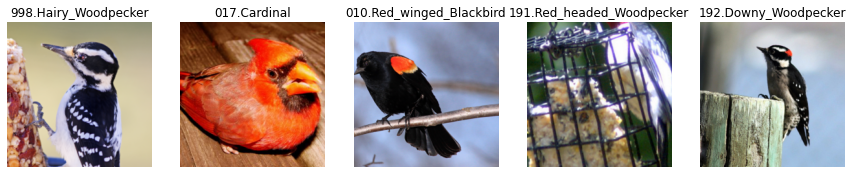

In [23]:
# check out some of the images in a batch. Because we're using image augmentation to crop and alter the images
# some of these may look a bit wierd
dls.show_batch(nrows=1, ncols=5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


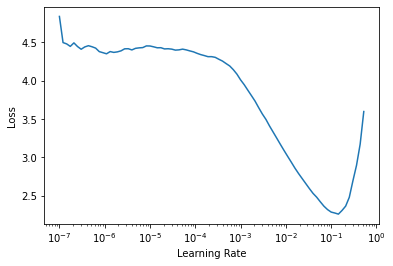

In [28]:
#fastai gives you a tool to find a good learning rate. This is really cool vs. guessing 
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [25]:
# The recommend using a learning rate one order of magnitude less than the LR that gives the minimum loss
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 8.32e-04


In [29]:
# Let's do a short training run.  Whereas I used resnet50 when training my model with 
# all 200 species in the dataset, I found the resnet50 required much more data than I have here, 
# with the smaller dataset of birds typically found in my backyard. So I'm using resnet34 here
# Not bad, we're already at about 82% accuracy after just 2 epochs
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=1.20e-02)

epoch,train_loss,valid_loss,error_rate,time
0,2.124566,0.635874,0.194872,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.525984,1.786019,0.323077,00:12
1,0.551271,0.746173,0.174359,00:12


In [30]:
# You can check out which bird species tend to get confused with other species of birds.
# e.g., Fish Crows get confused with Common Ravens
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=3)

[('118.House_Sparrow', '129.Song_Sparrow', 6),
 ('133.White_throated_Sparrow', '129.Song_Sparrow', 4),
 ('195.Carolina_Wren', '076.Dark_eyed_Junco', 3),
 ('998.Hairy_Woodpecker', '192.Downy_Woodpecker', 3)]

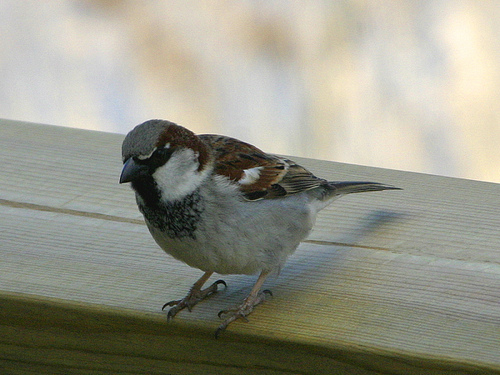

In [34]:
# No wonder.  Heres a sample House Sparrow. 
PILImage.create((path/"118.House_Sparrow").ls()[0])

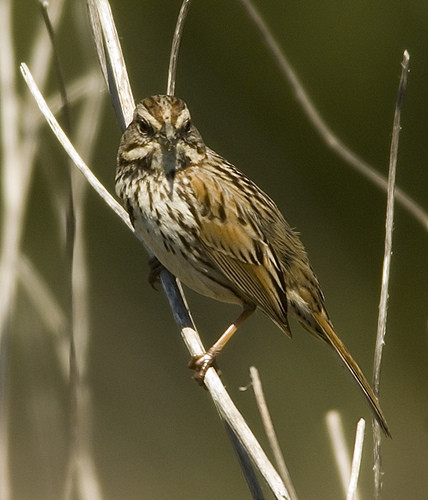

In [32]:
# And here's a Song Sparrow.  They are pretty similar. So this gives us some confidence that the model is 
# working, although I'm not sure how we're going to improve on this much. I doubt more training or a slightly better model
#is going to help us tell these birds apart
PILImage.create((path/"129.Song_Sparrow").ls()[0])

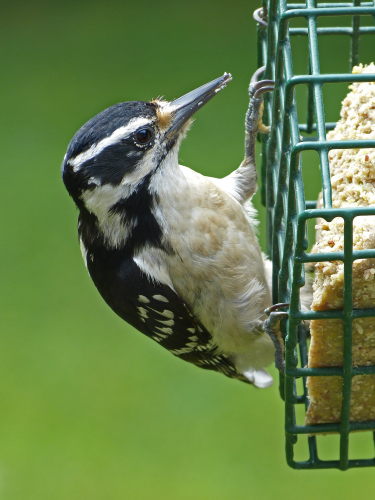

In [36]:
# Here's a sample Hairy Woodpecker picture
PILImage.create((path/"998.Hairy_Woodpecker").ls()[1])

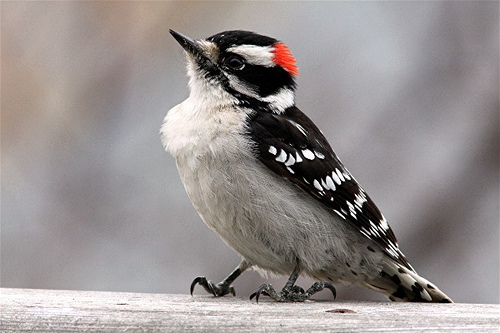

In [37]:
# And here's a Downy Woodpecker.  They appear fairly similar. 
# So it's not surprising that the model sometimes gets them confused.  So again, I'm not sure how much better 
# we're going to do with a better model or more training. 
PILImage.create((path/"192.Downy_Woodpecker").ls()[1])

In [42]:
# OK let's try to do a bit better.  If you use to_fp16, the GPU uses lower accuracy on its calculations
# so training is a bit faster. Let's run training for 3 epochs with our original learning rate. For these epochs, fastai keeps
# the resnet layers frozen, and we're focusing on the final layer which is hopefully tuned to identify the birds
learn = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fit_one_cycle(3,1.20e-02)

epoch,train_loss,valid_loss,error_rate,time
0,3.362493,2.541496,0.461538,00:10
1,2.026616,1.565856,0.302564,00:10
2,1.402199,0.851518,0.179487,00:10


In [43]:
# Then unfreeze, which lets us start modifying the weights in the resnet pretrained layers
learn.unfreeze()

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=1.3182567499825382e-06)

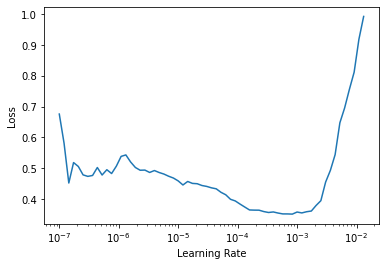

In [44]:
# Having done dome training, and unfrozen the resnet layers, let's see what the appropriate learning rate is now
learn.lr_find()

In [45]:
# It looks like the learning rate is good between 1e-3 and 1e-4. So we'll choose a learning rate in that area (1e-4)
# We'll change the learning rate and run for 6 epochs 
# Great!  I'm now over 91% accuracy!
learn.fit_one_cycle(6, lr_max=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.562878,0.554831,0.143590,00:11
1,0.396448,0.490221,0.143590,00:11
2,0.295410,0.430628,0.102564,00:11
3,0.228433,0.379487,0.102564,00:10
4,0.181883,0.364872,0.097436,00:10
5,0.166524,0.360004,0.087179,00:11


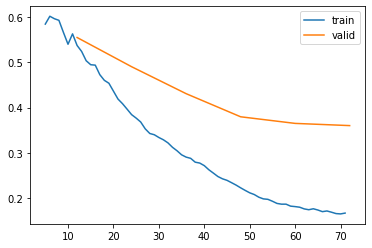

In [46]:
# Check the loss for the training and validation sets.  We're overfitting according to the loss
# although we did continue to improve on accuracy throughout the training, so I'm not concerned.
learn.recorder.plot_loss()

In [48]:
# fastai also let's you train using the fine_tune method. It automatically picks the learning rates.
# Let's see if it does better that what we did earlier with the fit_one_cycle method
# Try it for 3 epochs with resnet weights frozen, and then unfreeze for 6 epochs
# By the end we're rally hitting the limit of what we can do with this model.  It's not improving at all.
learn = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,4.463789,2.827213,0.815385,00:10
1,3.273565,0.861832,0.225641,00:10
2,2.198112,0.535868,0.169231,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.357721,0.441824,0.128205,00:10
1,0.278115,0.376993,0.107692,00:10
2,0.222873,0.340224,0.097436,00:10
3,0.169532,0.311502,0.087179,00:10
4,0.139495,0.323951,0.087179,00:10
5,0.121282,0.324271,0.087179,00:10


In [52]:
# Let's see how our "most confused" analysis looks now, with the better model.
# It's much better. I had to set the minimum value to 1 before I got anything
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=1)

[('133.White_throated_Sparrow', '076.Dark_eyed_Junco', 2),
 ('192.Downy_Woodpecker', '998.Hairy_Woodpecker', 2),
 ('998.Hairy_Woodpecker', '192.Downy_Woodpecker', 2),
 ('047.American_Goldfinch', '998.black-capped chickadee', 1),
 ('073.Blue_Jay', '133.White_throated_Sparrow', 1),
 ('094.White_breasted_Nuthatch', '036.Northern_Flicker', 1),
 ('094.White_breasted_Nuthatch', '192.Downy_Woodpecker', 1),
 ('118.House_Sparrow', '129.Song_Sparrow', 1),
 ('118.House_Sparrow', '195.Carolina_Wren', 1),
 ('129.Song_Sparrow', '118.House_Sparrow', 1),
 ('133.White_throated_Sparrow', '129.Song_Sparrow', 1),
 ('191.Red_headed_Woodpecker', '017.Cardinal', 1),
 ('191.Red_headed_Woodpecker', '189.Red_bellied_Woodpecker', 1),
 ('195.Carolina_Wren', '118.House_Sparrow', 1)]

In [54]:
# pick a random image in the test set
image_path=dls.train_ds.items[9]
image_path

Path('189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0023_181958.jpg')

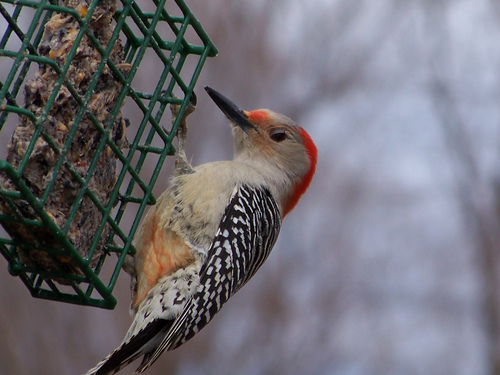

In [55]:
im=PILImage.create(image_path)
im

In [56]:
# try a prediction.  Nice!  It got it right
learn.predict(im)

('189.Red_bellied_Woodpecker',
 tensor(11),
 tensor([1.4024e-07, 3.6922e-05, 5.3653e-07, 2.3634e-04, 1.5434e-06, 8.8632e-07, 7.4200e-07, 2.4202e-05, 1.1560e-06, 1.0796e-06, 3.8318e-05, 9.9741e-01, 2.2076e-03, 4.6736e-06, 2.1702e-06, 2.3481e-05,
         1.7387e-06, 5.2290e-06]))